In [1]:
from azure.ai.ml import command, Input, MLClient
from azure.identity import DefaultAzureCredential
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes, InputOutputModes
from azure.ai.ml.dsl import pipeline
from dotenv import load_dotenv
import pandas as pd
import os

# specify the details of the workspace and assets created in the setup notebook
SUBSCRIPTION_ID = "e5615bfe-b43b-41ce-bccb-b78867c2ce63"
RESOURCE_GROUP = "rg-dp100-demo-001"
WORKSPACE_NAME = "mlw-dp100-demo"
DATASTORE_NAME = "diabtesblobdatastore"
STORAGE_ACCOUNT_NAME = "stdp100demo"
CONTAINER_NAME = "diabetesdatacontainer"
STORAGE_ACC_SAS_TOKEN = os.getenv("STORAGE_ACC_SAS_TOKEN")
DATASTORE_NAME = "blob_diabetes_datastore_sas"
MLTABLE_DATA_ASSET_NAME="mltable_diabetes_data_asset"
URIFILE_DATA_ASSET_NAME="urifile_diabetes_data_asset"
COMPUTE_CLUSTER = "vmcluster-ml-dev"
# get a handle to the subscription
load_dotenv("../python.env")

ml_client = MLClient(DefaultAzureCredential(), 
                     subscription_id=SUBSCRIPTION_ID, 
                     resource_group_name=RESOURCE_GROUP,
                     workspace_name=WORKSPACE_NAME)

In [2]:
# to ensure we are using the latest version of the data:
data_asset_tuple = [(asset.name, asset.latest_version) for asset in ml_client.data.list() if asset.name == MLTABLE_DATA_ASSET_NAME][0]
data_asset = ml_client.data.get(name=data_asset_tuple[0], version=data_asset_tuple[1])
data_asset.path

'azureml://subscriptions/e5615bfe-b43b-41ce-bccb-b78867c2ce63/resourcegroups/rg-dp100-demo-001/workspaces/mlw-dp100-demo/datastores/blob_diabetes_datastore_sas/paths/diabetes_mltable/'

## I. Using AutoML

### 1. With the MLTable asset where `colocated=True`

- Important reference: https://learn.microsoft.com/en-us/azure/machine-learning/how-to-configure-auto-train?view=azureml-api-2&tabs=python
- In order to provide training data to AutoML in SDK v2 you need to upload it into the cloud through an MLTable.
- Requirements for loading data into an MLTable:
    - Data must be in tabular form.
    - The value to predict, target column, must be in the data.

In [3]:
# once we get the data asset, we need to create a valid Input object to pass to the automl job
# the Input object needs 2 key pieces of information: the type and the path
# the syntax for path is "azureml:<data_asset_name>:<data_asset_version>"
# the syntax for type is "AssetTypes.<type>" where type is one of the following: URI_FILE, URI_FOLDER, MLTABLE
input_path = f"azureml:{data_asset.name}:{data_asset.version}"
input_path

'azureml:mltable_diabetes_data_asset:1'

In [4]:
my_training_data_input = Input(type=AssetTypes.MLTABLE, # only MLTABLE is supported for automl
                               path=input_path)

In [5]:
from azure.ai.ml import automl

# configure the classification job
classification_job = automl.classification(
    compute=COMPUTE_CLUSTER,
    experiment_name="auto-ml-diabetes-classification",
    training_data=my_training_data_input,
    target_column_name="Outcome",
    primary_metric="accuracy",
    n_cross_validations=5,
    enable_model_explainability=True
)

classification_job.set_limits(
    timeout_minutes=60, 
    trial_timeout_minutes=20, 
    max_trials=5,
    enable_early_termination=True,
)

In [6]:
# submit the AutoML job
returned_job = ml_client.jobs.create_or_update(
    classification_job
) 

In [7]:
# You can monitor AutoML job runs in the Azure Machine Learning studio. 
# To get a direct link to the AutoML job by running the following code:
aml_url = returned_job.studio_url
print("Monitor your job at", aml_url)

Monitor your job at https://ml.azure.com/runs/wheat_leather_b703wm8yjl?wsid=/subscriptions/e5615bfe-b43b-41ce-bccb-b78867c2ce63/resourcegroups/rg-dp100-demo-001/workspaces/mlw-dp100-demo&tid=3c2288b7-c4ac-4ad8-a4f3-32a569108be3


### 2. Repeat with the MLTable asset where `colocated=False`

In [10]:
# configure the data input
data_asset_tuple = [(asset.name, asset.latest_version) for asset in ml_client.data.list() if asset.name == "mltable_diabetes_data_asset2"][0]
data_asset = ml_client.data.get(name=data_asset_tuple[0], version=data_asset_tuple[1])
input_path = f"azureml:{data_asset.name}:{data_asset.version}"
print(input_path)
my_training_data_input = Input(type=AssetTypes.MLTABLE, # only MLTABLE is supported for automl
                               path=input_path)

# configure the classification job
classification_job = automl.classification(
    compute=COMPUTE_CLUSTER,
    experiment_name="auto-ml-diabetes-classification",
    training_data=my_training_data_input,
    target_column_name="Outcome",
    primary_metric="accuracy",
    n_cross_validations=5,
    enable_model_explainability=True
)

classification_job.set_limits(
    timeout_minutes=60, 
    trial_timeout_minutes=20, 
    max_trials=5,
    enable_early_termination=True,
)

# submit the AutoML job
returned_job = ml_client.jobs.create_or_update(
    classification_job
) 
aml_url = returned_job.studio_url
print("Monitor your job at", aml_url)

azureml:mltable_diabetes_data_asset2:1
Monitor your job at https://ml.azure.com/runs/sad_horse_mx7y6pxzx6?wsid=/subscriptions/e5615bfe-b43b-41ce-bccb-b78867c2ce63/resourcegroups/rg-dp100-demo-001/workspaces/mlw-dp100-demo&tid=3c2288b7-c4ac-4ad8-a4f3-32a569108be3


### 3. Repeat with MLTable asset where `colocated=False` + compute instance instead of cluster

- This will throw an error "User starting the run is not an owner or assigned user to the Compute Instance".
- This is because we are sending the jobs as a Service Principal. If the job is sent from the AML workspace, or from VSCode connected to the workspace, (under the logged-in user's credential), this will be fine.

In [11]:
# configure the data input
data_asset_tuple = [(asset.name, asset.latest_version) for asset in ml_client.data.list() if asset.name == "mltable_diabetes_data_asset2"][0]
data_asset = ml_client.data.get(name=data_asset_tuple[0], version=data_asset_tuple[1])
input_path = f"azureml:{data_asset.name}:{data_asset.version}"
print(input_path)
my_training_data_input = Input(type=AssetTypes.MLTABLE, # only MLTABLE is supported for automl
                               path=input_path)

# configure the classification job
classification_job = automl.classification(
    compute="vm-ml-dev",
    experiment_name="auto-ml-diabetes-classification",
    training_data=my_training_data_input,
    target_column_name="Outcome",
    primary_metric="accuracy",
    n_cross_validations=5,
    enable_model_explainability=True
)

classification_job.set_limits(
    timeout_minutes=60, 
    trial_timeout_minutes=20, 
    max_trials=5,
    enable_early_termination=True,
)

# submit the AutoML job
returned_job = ml_client.jobs.create_or_update(
    classification_job
) 
aml_url = returned_job.studio_url
print("Monitor your job at", aml_url)

azureml:mltable_diabetes_data_asset2:1
Monitor your job at https://ml.azure.com/runs/bright_picture_cpln9xc7h2?wsid=/subscriptions/e5615bfe-b43b-41ce-bccb-b78867c2ce63/resourcegroups/rg-dp100-demo-001/workspaces/mlw-dp100-demo&tid=3c2288b7-c4ac-4ad8-a4f3-32a569108be3


### 4. Repeat with additional config to allow certain models only

In [12]:
# configure the data input
data_asset_tuple = [(asset.name, asset.latest_version) for asset in ml_client.data.list() if asset.name == "mltable_diabetes_data_asset2"][0]
data_asset = ml_client.data.get(name=data_asset_tuple[0], version=data_asset_tuple[1])
input_path = f"azureml:{data_asset.name}:{data_asset.version}"
print(input_path)
my_training_data_input = Input(type=AssetTypes.MLTABLE, # only MLTABLE is supported for automl
                               path=input_path)

# configure the classification job
classification_job = automl.classification(
    compute=COMPUTE_CLUSTER,
    experiment_name="auto-ml-diabetes-classification",
    training_data=my_training_data_input,
    target_column_name="Outcome",
    primary_metric="accuracy",
    n_cross_validations=5,
    enable_model_explainability=True,
)

classification_job.set_limits(
    timeout_minutes=60, 
    trial_timeout_minutes=20, 
    max_trials=5,
    enable_early_termination=True,
)

# Training properties are optional
classification_job.set_training(
    allowed_training_algorithms=["SVM", "MultinomialNaiveBayes", "LogisticRegression", "LightGBM", "XGBoostClassifier"], 
    enable_onnx_compatible_models=True,
    enable_stack_ensemble=True,
    enable_vote_ensemble=True,
)

# submit the AutoML job
returned_job = ml_client.jobs.create_or_update(
    classification_job
) 
aml_url = returned_job.studio_url
print("Monitor your job at", aml_url)

azureml:mltable_diabetes_data_asset2:1
Monitor your job at https://ml.azure.com/runs/silver_clock_yhft57nzyq?wsid=/subscriptions/e5615bfe-b43b-41ce-bccb-b78867c2ce63/resourcegroups/rg-dp100-demo-001/workspaces/mlw-dp100-demo&tid=3c2288b7-c4ac-4ad8-a4f3-32a569108be3


## II. Manual Training with exploration

- References: https://github.com/MicrosoftLearning/mslearn-azure-ml/blob/main/Labs/08/src/Train%20classification%20model.ipynb
- Main modification: 
    - changed the data source to data asset on workspace
    - changed the column names used as the datasets are different

### 1. Read data from data asset

In [7]:
data_asset_tuple = [(asset.name, asset.latest_version) for asset in ml_client.data.list() if asset.name == URIFILE_DATA_ASSET_NAME][0]
print(data_asset_tuple)
data_asset = ml_client.data.get(name=data_asset_tuple[0], version=data_asset_tuple[1])
df = pd.read_csv(data_asset.path)
df.head(2)

('urifile_diabetes_data_asset', '1')


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0


### 1. Read data from local (alternative, for offline testing of codes)

In [3]:
df = pd.read_csv('./data/diabetes.csv')
df.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0


In [5]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

### 2. Split data

In [6]:
from sklearn.model_selection import train_test_split

X = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']].values
y = df['Outcome'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

### 3. Train a model

In [7]:
from sklearn.linear_model import LogisticRegression

print("Training model...")
model = LogisticRegression(C=1/0.1, solver="liblinear").fit(X_train, y_train)

Training model...


### 4. Evaluate Model

Accuracy: 0.7835497835497836
AUC: 0.8363745911516612


Text(0.5, 1.0, 'ROC Curve')

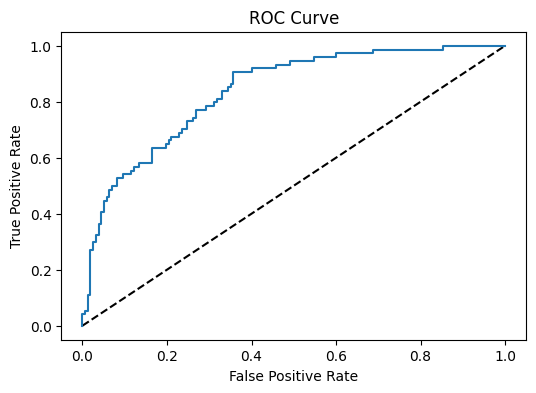

In [8]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

y_hat = model.predict(X_test)
acc = np.average(y_hat == y_test)
print('Accuracy:', acc)

y_scores = model.predict_proba(X_test)
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))

# plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
fig = plt.figure(figsize=(6, 4))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

## III. Manual training with train.py script

with the following folder structure, we can pass different arguments to the training script inside the `diabetes` folder in terminal 
```bash
.
└── diabetes/
    ├── data/
    │   └── diabetes.csv
    └── train.py
```

```bash
$ python train.py --training_data ./data/diabetes.csv
************************************************************
Reading data...
Splitting data...
Training model...
Accuracy: 0.7792207792207793
AUC: 0.8357720778102944
************************************************************
```

```bash
$ python train.py --training_data ./data/diabetes.csv --reg_rate 0.05
************************************************************
Reading data...
Splitting data...
Training model...
Accuracy: 0.7835497835497836
AUC: 0.8366328111551041
************************************************************
```

## IV. Submitting the Training Job to AML

In [3]:
# getting the environment
envs = ml_client.environments.list()
print([(env.name, env.latest_version) for env in envs])
diabetes_env = ml_client.environments.get(name='diabetes-env', version=1)

[('diabetes-env', '1'), ('titanic-env', '5'), ('CliV2AnonymousEnvironment', '0'), ('pytorch-env', '1'), ('testenv-conda-002', '1'), ('testenv-conda', '1'), ('testenv', '1'), ('AzureML-AI-Studio-Development', '1'), ('AzureML-ACPT-pytorch-1.13-py38-cuda11.7-gpu', '10'), ('AzureML-ACPT-pytorch-1.12-py38-cuda11.6-gpu', '14'), ('AzureML-ACPT-pytorch-1.12-py39-cuda11.6-gpu', '14'), ('AzureML-ACPT-pytorch-1.11-py38-cuda11.5-gpu', '14'), ('AzureML-ACPT-pytorch-1.11-py38-cuda11.3-gpu', '17'), ('AzureML-responsibleai-0.21-ubuntu20.04-py38-cpu', '7'), ('AzureML-responsibleai-0.20-ubuntu20.04-py38-cpu', '9'), ('AzureML-tensorflow-2.5-ubuntu20.04-py38-cuda11-gpu', '27'), ('AzureML-tensorflow-2.6-ubuntu20.04-py38-cuda11-gpu', '26'), ('AzureML-tensorflow-2.7-ubuntu20.04-py38-cuda11-gpu', '26'), ('AzureML-sklearn-1.0-ubuntu20.04-py38-cpu', '36'), ('AzureML-pytorch-1.10-ubuntu18.04-py38-cuda11-gpu', '36'), ('AzureML-pytorch-1.9-ubuntu18.04-py37-cuda11-gpu', '44'), ('AzureML-pytorch-1.8-ubuntu18.04-py37

In [8]:
# Inside author_training_job.py
from azure.ai.ml import command

# configure job
command_job = command(
    code="./src",
    command=f"python train.py --training_data {data_asset.path}",
    environment=diabetes_env,
    compute=COMPUTE_CLUSTER,
    display_name="train-diabetes-clf-model",
    experiment_name="train-diabetes-classification-model"
    )


# added inputs to avoid specifying the path in the command via f-string and {}, causing conflict with the other {{}} in the command
command_job = command(
    code="./src",
    command="python train_mlflow_autolog.py --training_data ${{inputs.training_data}}",

    inputs={
        "training_data": data_asset.path 
    },
    environment=diabetes_env,
    compute=COMPUTE_CLUSTER,
    display_name="train-diabetes-clf-model",
    experiment_name="train-diabetes-classification-model"
    )

# submit the job and get the URL to see the status on AML
returned_job = ml_client.jobs.create_or_update(command_job)
returned_job

Class AutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class AutoDeleteConditionSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseAutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class IntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ProtectionLevelSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseIntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Uploading src (0.0 MBs): 100%|########

Experiment,Name,Type,Status,Details Page
train-diabetes-classification-model,sleepy_kitchen_0bbkm591vp,command,Starting,Link to Azure Machine Learning studio


## V. Repeat Job with MLflow autologging enabled + add custom logging param

In [11]:
from azure.ai.ml import command


diabetes_env = ml_client.environments.get(name='diabetes-env', version=1)
# configure job
command_job = command(
    code="./src",
    command=f"python train_mlflow_autolog.py --training_data {data_asset.path}",
    inputs={
        "training_data": data_asset.path # added this to avoid specifying the path in the command via f-string and {}, causing conflict with the other {{}} in the command
    },
    environment=diabetes_env,
    compute=COMPUTE_CLUSTER,
    display_name="train-diabetes-clf-model-mlflow-autolog-customlog",
    experiment_name="train-diabetes-classification-model-mlflow-autolog"
    )

# added inputs to avoid specifying the path in the command via f-string and {}, causing conflict with the other {{}} in the command
command_job = command(
    code="./src",
    command="python train_mlflow_autolog.py --training_data ${{inputs.training_data}}",

    inputs={
        "training_data": data_asset.path 
    },
    environment=diabetes_env,
    compute=COMPUTE_CLUSTER,
    display_name="train-diabetes-clf-model-mlflow-autolog-customlog",
    experiment_name="train-diabetes-classification-model-mlflow-autolog"
    )


# submit the job and get the URL to see the status on AML
returned_job = ml_client.jobs.create_or_update(command_job)
returned_job

Uploading src (0.01 MBs): 100%|##########| 6157/6157 [00:00<00:00, 11576.09it/s]




Experiment,Name,Type,Status,Details Page
train-diabetes-classification-model-mlflow-autolog,gifted_apricot_rm0c9mbvlv,command,Starting,Link to Azure Machine Learning studio


## VI. Repeat Job with logging the model to MLflow

In [4]:
# getting the environment
envs = ml_client.environments.list()
print([(env.name, env.latest_version) for env in envs])
diabetes_env = ml_client.environments.get(name='diabetes-env', version=1)

# test reading the data asset
data_asset_tuple = [(asset.name, asset.latest_version) for asset in ml_client.data.list() if asset.name == URIFILE_DATA_ASSET_NAME][0]
print(data_asset_tuple)
data_asset = ml_client.data.get(name=data_asset_tuple[0], version=data_asset_tuple[1])
df = pd.read_csv(data_asset.path)
print(df.head(2))

diabetes_env = ml_client.environments.get(name='diabetes-env', version=1)


[('diabetes-env', '1'), ('titanic-env', '5'), ('CliV2AnonymousEnvironment', '0'), ('pytorch-env', '1'), ('testenv-conda-002', '1'), ('testenv-conda', '1'), ('testenv', '1'), ('AzureML-AI-Studio-Development', '1'), ('AzureML-ACPT-pytorch-1.13-py38-cuda11.7-gpu', '10'), ('AzureML-ACPT-pytorch-1.12-py38-cuda11.6-gpu', '14'), ('AzureML-ACPT-pytorch-1.12-py39-cuda11.6-gpu', '14'), ('AzureML-ACPT-pytorch-1.11-py38-cuda11.5-gpu', '14'), ('AzureML-ACPT-pytorch-1.11-py38-cuda11.3-gpu', '17'), ('AzureML-responsibleai-0.21-ubuntu20.04-py38-cpu', '7'), ('AzureML-responsibleai-0.20-ubuntu20.04-py38-cpu', '9'), ('AzureML-tensorflow-2.5-ubuntu20.04-py38-cuda11-gpu', '27'), ('AzureML-tensorflow-2.6-ubuntu20.04-py38-cuda11-gpu', '26'), ('AzureML-tensorflow-2.7-ubuntu20.04-py38-cuda11-gpu', '26'), ('AzureML-sklearn-1.0-ubuntu20.04-py38-cpu', '36'), ('AzureML-pytorch-1.10-ubuntu18.04-py38-cuda11-gpu', '36'), ('AzureML-pytorch-1.9-ubuntu18.04-py37-cuda11-gpu', '44'), ('AzureML-pytorch-1.8-ubuntu18.04-py37

In [6]:
from azure.ai.ml import command


# added inputs to avoid specifying the path in the command via f-string and {}, causing conflict with the other {{}} in the command
command_job = command(
    code="./src",
    command="python train_mlflow_log_model.py --training_data ${{inputs.training_data}} --reg_rate ${{inputs.reg_rate}} --registered_model_name ${{inputs.registered_model_name}}",

    inputs={
        "reg_rate": 0.01,
        "training_data": data_asset.path, # added this to avoid specifying the path in the command via f-string and {}, causing conflict with the other {{}} in the command
        "registered_model_name": "diabetes_classification_model_reg_rate_0.01"
    },
    environment=diabetes_env,
    compute=COMPUTE_CLUSTER,
    display_name="train-diabetes-clf-model-modellog",
    experiment_name="train-diabetes-classification-model-modellog"
    )
# or you can specify the experiment name outside of the command()
# command_job.experiment_name="bla-bla"
# command_job.display_name = "bla-bla"

# submit the job and get the URL to see the status on AML
returned_job = ml_client.jobs.create_or_update(command_job)
aml_url = returned_job.studio_url
print("Monitor your job at", aml_url)

Monitor your job at https://ml.azure.com/runs/icy_library_fn7vwqxgny?wsid=/subscriptions/e5615bfe-b43b-41ce-bccb-b78867c2ce63/resourcegroups/rg-dp100-demo-001/workspaces/mlw-dp100-demo&tid=3c2288b7-c4ac-4ad8-a4f3-32a569108be3


## (TBU) Interacting with Logged Experiments

There seems to be no modules to interact with the workspace experiments - TBU

In [30]:
import mlflow

exp = mlflow.get_experiment_by_name("train-diabetes-classification-model-mlflow-autolog")
print(exp)

None


In [19]:
# getting the jobs in the workspace
jobs = ml_client.jobs.list()
for job in jobs:
    print(job.display_name, '\t', job.name, '\t', job.status)

train-diabetes-clf-model-mlflow-autolog-customlog 	 gifted_apricot_rm0c9mbvlv 	 Completed
train-diabetes-clf-model-mlflow-autolog 	 loyal_stem_qyy1038xml 	 Completed
train-diabetes-clf-model 	 sleepy_kitchen_0bbkm591vp 	 Completed
silver_clock_yhft57nzyq 	 silver_clock_yhft57nzyq 	 Completed
using-compute-instance-colocated-False 	 bright_picture_cpln9xc7h2 	 Failed
using-compute-cluster-mltable-colocated-False 	 sad_horse_mx7y6pxzx6 	 Completed
using-compute-cluster-mltable-colocated-True 	 wheat_leather_b703wm8yjl 	 Completed
bubbly_eagle_lr9b3syt3y 	 bubbly_eagle_lr9b3syt3y 	 Failed
musing_nest_ltzhml7vdw 	 musing_nest_ltzhml7vdw 	 Failed
titanic_survival_pipeline 	 wheat_beach_nbfwwr7xkj 	 Completed
titanic_survival_pipeline 	 lime_star_v14v97j9pg 	 Completed
titanic_survival_pipeline 	 brave_skin_n7fkgtsrm7 	 Failed
titanic_survival_pipeline 	 upbeat_chin_0h2274rc0m 	 Completed
titanic_survival_pipeline 	 tough_fork_bt7c06bxmx 	 Failed
titanic_survival_pipeline 	 magenta_cheetah_g

In [28]:
#  get job by name:
job = ml_client.jobs.get(name="gifted_apricot_rm0c9mbvlv")
# job.__dict__

In [29]:
job._parameters

{'training_data': 'azureml://subscriptions/e5615bfe-b43b-41ce-bccb-b78867c2ce63/resourcegroups/rg-dp100-demo-001/workspaces/mlw-dp100-demo/datastores/blob_diabetes_datastore_sas/paths/diabetes.csv',
 'reg_rate': '0.01',
 'C': '100.0',
 'class_weight': 'None',
 'dual': 'False',
 'fit_intercept': 'True',
 'intercept_scaling': '1',
 'l1_ratio': 'None',
 'max_iter': '100',
 'multi_class': 'auto',
 'n_jobs': 'None',
 'penalty': 'l2',
 'random_state': 'None',
 'solver': 'liblinear',
 'tol': '0.0001',
 'verbose': '0',
 'warm_start': 'False'}

## VII. Hyperparameter Tuning with Sweeping

In [13]:
from azure.ai.ml import command
from azure.ai.ml.sweep import Choice

# getting the environment
envs = ml_client.environments.list()
print([(env.name, env.latest_version) for env in envs])
diabetes_env = ml_client.environments.get(name='diabetes-env', version=1)

# test reading the data asset
data_asset_tuple = [(asset.name, asset.latest_version) for asset in ml_client.data.list() if asset.name == URIFILE_DATA_ASSET_NAME][0]
print(data_asset_tuple)
data_asset = ml_client.data.get(name=data_asset_tuple[0], version=data_asset_tuple[1])
df = pd.read_csv(data_asset.path)
print(df.head(2))

# configure command job as base, just like before
job = command(
    code="./src",
    command="python train_mlflow_sweep_acc.py --training_data ${{inputs.training_data}} --reg_rate ${{inputs.reg_rate}}",

    inputs={
        "reg_rate": 0.01,
        "training_data": data_asset.path # added this to avoid specifying the path in the command via f-string and {}, causing conflict with the other {{}} in the command
    },
    environment=diabetes_env,
    compute=COMPUTE_CLUSTER,
    )

# then override your input parameters with your search space
# note the consistent param name "reg_rate"
command_job_for_sweep = job(
    reg_rate=Choice(values=[0.01, 0.1, 1]),
)

# apply the sweep parameter to obtain the sweep_job
sweep_job = command_job_for_sweep.sweep(
    compute=COMPUTE_CLUSTER,
    sampling_algorithm="grid",
    primary_metric="Accuracy",
    goal="Maximize",
)

# set the name of the sweep job experiment
sweep_job.experiment_name="sweep-example"

# define the limits for this sweep
sweep_job.set_limits(max_total_trials=4, max_concurrent_trials=2, timeout=7200)

[('diabetes-env', '1'), ('titanic-env', '5'), ('CliV2AnonymousEnvironment', '0'), ('pytorch-env', '1'), ('testenv-conda-002', '1'), ('testenv-conda', '1'), ('testenv', '1'), ('AzureML-AI-Studio-Development', '1'), ('AzureML-ACPT-pytorch-1.13-py38-cuda11.7-gpu', '10'), ('AzureML-ACPT-pytorch-1.12-py38-cuda11.6-gpu', '14'), ('AzureML-ACPT-pytorch-1.12-py39-cuda11.6-gpu', '14'), ('AzureML-ACPT-pytorch-1.11-py38-cuda11.5-gpu', '14'), ('AzureML-ACPT-pytorch-1.11-py38-cuda11.3-gpu', '17'), ('AzureML-responsibleai-0.21-ubuntu20.04-py38-cpu', '7'), ('AzureML-responsibleai-0.20-ubuntu20.04-py38-cpu', '9'), ('AzureML-tensorflow-2.5-ubuntu20.04-py38-cuda11-gpu', '27'), ('AzureML-tensorflow-2.6-ubuntu20.04-py38-cuda11-gpu', '26'), ('AzureML-tensorflow-2.7-ubuntu20.04-py38-cuda11-gpu', '26'), ('AzureML-sklearn-1.0-ubuntu20.04-py38-cpu', '36'), ('AzureML-pytorch-1.10-ubuntu18.04-py38-cuda11-gpu', '36'), ('AzureML-pytorch-1.9-ubuntu18.04-py37-cuda11-gpu', '44'), ('AzureML-pytorch-1.8-ubuntu18.04-py37

In [14]:
# submit the sweep
returned_sweep_job = ml_client.create_or_update(sweep_job)

In [15]:
aml_url = returned_sweep_job.studio_url
print("Monitor your job at", aml_url)

Monitor your job at https://ml.azure.com/runs/eager_fox_xvcpz9zyg5?wsid=/subscriptions/e5615bfe-b43b-41ce-bccb-b78867c2ce63/resourcegroups/rg-dp100-demo-001/workspaces/mlw-dp100-demo&tid=3c2288b7-c4ac-4ad8-a4f3-32a569108be3


## VIII. Sweeping with Logging Model to MLflow

In [7]:
# getting the environment
envs = ml_client.environments.list()
print([(env.name, env.latest_version) for env in envs])
diabetes_env = ml_client.environments.get(name='diabetes-env', version=1)

# test reading the data asset
data_asset_tuple = [(asset.name, asset.latest_version) for asset in ml_client.data.list() if asset.name == URIFILE_DATA_ASSET_NAME][0]
print(data_asset_tuple)
data_asset = ml_client.data.get(name=data_asset_tuple[0], version=data_asset_tuple[1])
df = pd.read_csv(data_asset.path)
print(df.head(2))

diabetes_env = ml_client.environments.get(name='diabetes-env', version=1)


[('diabetes-env', '1'), ('titanic-env', '5'), ('CliV2AnonymousEnvironment', '0'), ('pytorch-env', '1'), ('testenv-conda-002', '1'), ('testenv-conda', '1'), ('testenv', '1'), ('AzureML-AI-Studio-Development', '1'), ('AzureML-ACPT-pytorch-1.13-py38-cuda11.7-gpu', '10'), ('AzureML-ACPT-pytorch-1.12-py38-cuda11.6-gpu', '14'), ('AzureML-ACPT-pytorch-1.12-py39-cuda11.6-gpu', '14'), ('AzureML-ACPT-pytorch-1.11-py38-cuda11.5-gpu', '14'), ('AzureML-ACPT-pytorch-1.11-py38-cuda11.3-gpu', '17'), ('AzureML-responsibleai-0.21-ubuntu20.04-py38-cpu', '7'), ('AzureML-responsibleai-0.20-ubuntu20.04-py38-cpu', '9'), ('AzureML-tensorflow-2.5-ubuntu20.04-py38-cuda11-gpu', '27'), ('AzureML-tensorflow-2.6-ubuntu20.04-py38-cuda11-gpu', '26'), ('AzureML-tensorflow-2.7-ubuntu20.04-py38-cuda11-gpu', '26'), ('AzureML-sklearn-1.0-ubuntu20.04-py38-cpu', '36'), ('AzureML-pytorch-1.10-ubuntu18.04-py38-cuda11-gpu', '36'), ('AzureML-pytorch-1.9-ubuntu18.04-py37-cuda11-gpu', '44'), ('AzureML-pytorch-1.8-ubuntu18.04-py37

In [8]:
from azure.ai.ml import command
from azure.ai.ml.sweep import Choice

# configure command job as base, just like before
job = command(
    code="./src",
    command="python train_mlflow_autolog_sweep_acc.py --training_data ${{inputs.training_data}} --reg_rate ${{inputs.reg_rate}}",

    inputs={
        "reg_rate": 0.01,
        "training_data": data_asset.path 
    },
    environment=diabetes_env,
    compute=COMPUTE_CLUSTER,
    )

# then override your input parameters with your search space
# note the consistent param name "reg_rate"
command_job_for_sweep = job(
    reg_rate=Choice(values=[0.001, 0.01, 0.1, 1, 10]),
)

# apply the sweep parameter to obtain the sweep_job
sweep_job = command_job_for_sweep.sweep(
    compute=COMPUTE_CLUSTER,
    sampling_algorithm="grid",
    primary_metric="Accuracy",
    goal="Maximize",
)

# set the name of the sweep job experiment
sweep_job.experiment_name="sweep-example-autolog"

# define the limits for this sweep
# for this small example when we know the total number of trials from the Choice list, we can set the same number to max_total_trials
sweep_job.set_limits(max_total_trials=5, max_concurrent_trials=2, timeout=7200)

# submit the sweep
returned_sweep_job = ml_client.create_or_update(sweep_job)

# get the direct URL to monitor
aml_url = returned_sweep_job.studio_url
print("Monitor your job at", aml_url)

Uploading src (0.01 MBs): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13021/13021 [00:00<00:00, 188978.51it/s]


Monitor your job at https://ml.azure.com/runs/sincere_whale_zrpg2nczf2?wsid=/subscriptions/e5615bfe-b43b-41ce-bccb-b78867c2ce63/resourcegroups/rg-dp100-demo-001/workspaces/mlw-dp100-demo&tid=3c2288b7-c4ac-4ad8-a4f3-32a569108be3


## IX. Model Deployment to Real-Time Endpoint

### 1. Creating an Endpoint (managed endpoint)

In [9]:
from azure.ai.ml.entities import ManagedOnlineEndpoint

# create an online endpoint
endpoint = ManagedOnlineEndpoint(
    name="endpoint-diabetes-prediction",
    description="Managed online endpoint for diabetes prediction.",
    auth_mode="key",
)

ml_client.begin_create_or_update(endpoint).result()

ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://endpoint-diabetes-prediction.japaneast.inference.ml.azure.com/score', 'openapi_uri': 'https://endpoint-diabetes-prediction.japaneast.inference.ml.azure.com/swagger.json', 'name': 'endpoint-diabetes-prediction', 'description': 'Managed online endpoint for diabetes prediction.', 'tags': {}, 'properties': {'azureml.onlineendpointid': '/subscriptions/e5615bfe-b43b-41ce-bccb-b78867c2ce63/resourcegroups/rg-dp100-demo-001/providers/microsoft.machinelearningservices/workspaces/mlw-dp100-demo/onlineendpoints/endpoint-diabetes-prediction', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/e5615bfe-b43b-41ce-bccb-b78867c2ce63/providers/Microsoft.MachineLearningServices/locations/japaneast/mfeOperationsStatus/oe:af3d7f07-5db5-4a8b-8152-658095ccbf88:0b203e32-ce46-476a-98e8-b5a60ea58654?api-version=2022-02-01-preview'}, 'print_as_yaml': True, 'id': '/subscriptions

### 2. Deploy Saved MLFlow Model from Local Path

Source of the model: <br>
`Jobs/sweep-example-autolog/sincere_whale_zrpg2nczf2/sincere_whale_zrpg2nczf2_3`

In [13]:
from azure.ai.ml.entities import Model, ManagedOnlineDeployment
from azure.ai.ml.constants import AssetTypes

# create a blue deployment
model = Model(
    path="./models/diabetes_classification_model_2",
    type=AssetTypes.MLFLOW_MODEL,
    description="Sample model registered from local path.",
)

blue_deployment = ManagedOnlineDeployment(
    name="blue",
    endpoint_name="endpoint-diabetes-prediction",
    model=model,
    instance_type="Standard_DS2_v2",
    instance_count=1,
)

ml_client.online_deployments.begin_create_or_update(blue_deployment).result()

Instance type Standard_DS2_v2 may be too small for compute resources. Minimum recommended compute SKU is Standard_DS3_v2 for general purpose endpoints. Learn more about SKUs here: https://learn.microsoft.com/en-us/azure/machine-learning/referencemanaged-online-endpoints-vm-sku-list
Check: endpoint endpoint-diabetes-prediction exists


..................................................................................................

ManagedOnlineDeployment({'private_network_connection': None, 'package_model': False, 'provisioning_state': 'Succeeded', 'endpoint_name': 'endpoint-diabetes-prediction', 'type': 'Managed', 'name': 'blue', 'description': None, 'tags': {}, 'properties': {'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/e5615bfe-b43b-41ce-bccb-b78867c2ce63/providers/Microsoft.MachineLearningServices/locations/japaneast/mfeOperationsStatus/od:af3d7f07-5db5-4a8b-8152-658095ccbf88:bc709a26-271e-472a-87d6-6847d00e083d?api-version=2023-04-01-preview'}, 'print_as_yaml': True, 'id': '/subscriptions/e5615bfe-b43b-41ce-bccb-b78867c2ce63/resourceGroups/rg-dp100-demo-001/providers/Microsoft.MachineLearningServices/workspaces/mlw-dp100-demo/onlineEndpoints/endpoint-diabetes-prediction/deployments/blue', 'Resource__source_path': None, 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/vm-ml-dev/code/Users/phuonglevu3112/AzureDevOps/dp-100/diabetes', 'creation_context': None, 'serialize':

### 3. Test the endpoint using key

In [19]:
import urllib.request
import json
import os
import ssl

def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
    if allowed and not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context

allowSelfSignedHttps(True) # this line is needed if you use self-signed certificate in your scoring service.

# Request data goes here
# More information can be found here:
# https://docs.microsoft.com/azure/machine-learning/how-to-deploy-advanced-entry-script
data =  {
  "input_data": [[6,148,72,35,0,33.6,0.627,50],
                 [1,85,66,29,0,26.6,0.351,31]], # needs a (-1,1) shape array where no.rows can be anything
  "params": {}
}

body = str.encode(json.dumps(data))

url = 'https://endpoint-diabetes-prediction.japaneast.inference.ml.azure.com/score'
api_key = 'uEKUMJuhmY88DyJzWelBGyBgXWYCLphR'
if not api_key:
    raise Exception("A key should be provided to invoke the endpoint")

# The azureml-model-deployment header will force the request to go to a specific deployment.
# Remove this header to have the request observe the endpoint traffic rules
headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key), 'azureml-model-deployment': 'blue' }
req = urllib.request.Request(url, body, headers)
try:
    response = urllib.request.urlopen(req)
    result = response.read()
    print(result)
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))
    print(error.info())
    print(error.read().decode("utf8", 'ignore'))

b'[1, 0]'


In [30]:
# let's mimic a stream of requests

def get_prediction(input_data: list, api_key:str):
    data =  {
    "input_data": input_data,
    "params": {}
    }

    body = str.encode(json.dumps(data))
    url = 'https://endpoint-diabetes-prediction.japaneast.inference.ml.azure.com/score'
    if not api_key:
        raise Exception("A key should be provided to invoke the endpoint")

    headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key), 'azureml-model-deployment': 'blue' }
    req = urllib.request.Request(url, body, headers)
    try:
        response = urllib.request.urlopen(req)
        result = response.read()
        return result
    except urllib.error.HTTPError as error:
        print("The request failed with status code: " + str(error.code))
        print(error.info())
        print(error.read().decode("utf8", 'ignore'))

In [24]:
df = pd.read_csv('./data/diabetes.csv')
df = df.drop(columns=['Outcome'], index=1)
df.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
2,8,183,64,0,0,23.3,0.672,32


In [38]:
from random import randint
from time import sleep

API_KEY = 'uEKUMJuhmY88DyJzWelBGyBgXWYCLphR'
for i in range(5):
    sample_data = df.sample(randint(1,10)).values.tolist()
    print(f"Iteration: {i+1}")
    output = get_prediction(sample_data, API_KEY)
    print(output)
    sleep(randint(1,10))


Iteration: 1
b'[0, 0, 1, 0, 0, 0, 0]'
Iteration: 2
b'[0]'
Iteration: 3
b'[0, 0, 0, 0]'
Iteration: 4
b'[0, 0, 0]'
Iteration: 5
b'[0, 0]'
